In [1]:
import xarray as xr
import altair as alt
import pandas as pd

In [2]:
ds = xr.open_dataset("/Users/elischwat/Downloads/isfs_20221030.nc")

## Declare variable prefix and suffix to filter data

In [3]:
VARIABLE_PREFIXES = ['dir_', 'spd_']

In [4]:
variables = [f for f in list(ds.data_vars) if any([prefix in f for prefix in VARIABLE_PREFIXES])]
variables


['dir_5m_c',
 'spd_5m_c',
 'dir_20m_c',
 'spd_20m_c',
 'dir_1m_c',
 'spd_1m_c',
 'dir_1m_uw',
 'spd_1m_uw',
 'dir_10m_ue',
 'spd_10m_ue',
 'dir_3m_c',
 'spd_3m_c',
 'dir_2m_c',
 'spd_2m_c',
 'dir_1m_d',
 'spd_1m_d',
 'dir_3m_d',
 'spd_3m_d',
 'dir_10m_uw',
 'spd_10m_uw',
 'dir_3m_uw',
 'spd_3m_uw',
 'dir_1m_ue',
 'spd_1m_ue',
 'dir_10m_d',
 'spd_10m_d',
 'dir_15m_c',
 'spd_15m_c',
 'dir_10m_c',
 'spd_10m_c',
 'dir_3m_ue',
 'spd_3m_ue']

## Convert dataset to dataframe

In [6]:
ds

<xarray.Dataset>
Dimensions:                    (time: 288)
Coordinates:
  * time                       (time) datetime64[ns] 2022-10-30T00:02:30 ... ...
Data variables: (12/1006)
    base_time                  datetime64[ns] ...
    counts_5m_c                (time) float64 ...
    u_5m_c                     (time) float32 ...
    v_5m_c                     (time) float32 ...
    w_5m_c                     (time) float32 ...
    tc_5m_c                    (time) float32 ...
    ...                         ...
    Load_Load__3_p3_c          (time) float32 ...
    Load_Load__4_p3_c          (time) float32 ...
    Load_Load__1_p4_c          (time) float32 ...
    Load_Load__2_p4_c          (time) float32 ...
    Load_Load__3_p4_c          (time) float32 ...
    Load_Load__4_p4_c          (time) float32 ...
Attributes:
    history:                   Created: 2022-10-30 00:05:06 +0000\n
    NIDAS_version:             v1.2-1669
    calibration_file_path:     /h/eol/isfs/isfs/projects/SOS/ISFS/cal_files/n...
    project_config:            /h/eol/isfs/isfs/projects/SOS/ISFS/config/sos....
    wind3d_horiz_coordinates:  geographic
    file_length_seconds:       86400
    wind3d_horiz_rotation:     1
    wind3d_tilt_correction:    0

In [11]:
[var for var in ds.data_vars if 'P_20m' in var]

['P_20m_c']

In [5]:
src = ds[variables].to_dataframe()

In [ ]:
src

## Parse height information from column names so measurement height is a column/index

In [290]:
def height_from_variable_name(name):
    if '_1m_' in name:
        return 1
    elif '_2m_' in name:
        return 2
    elif '_3m_' in name:
        return 3
    elif '_5m_' in name:
        return 5
    elif '_10m_' in name:
        return 10
    elif '_15m_' in name:
        return 15
    elif '_20m_' in name:
        return 20
def tower_from_variable_name(name):
    if '_d' in name:
        return 'd'
    elif '_c' in name:
        return 'c'
    elif '_ue' in name:
        return 'ue'
    elif 'uw' in name:
        return 'uw'
def measurement_from_variable_name(name):
    if 'dir_' in name:
        return 'wind direction'
    elif 'spd' in name:
        return 'wind speed'
    elif 'T_' in name:
        return 'temperature'

In [291]:
src = src.reset_index()
src = src.melt(id_vars='time', value_vars=[col for col in src.columns if any([prefix in col for prefix in VARIABLE_PREFIX])])

In [292]:
src['height'] = src['variable'].apply(height_from_variable_name)
src['tower'] = src['variable'].apply(tower_from_variable_name)
src['measurement'] = src['variable'].apply(measurement_from_variable_name)
src = src.set_index(['time'])

In [293]:
src

,variable,value,height,tower,measurement
time,,,,,
2022-10-30 00:02:30,dir_5m_c,297.616760,5,c,wind direction
2022-10-30 00:07:30,dir_5m_c,298.871155,5,c,wind direction
2022-10-30 00:12:30,dir_5m_c,299.039886,5,c,wind direction
2022-10-30 00:17:30,dir_5m_c,294.425781,5,c,wind direction
2022-10-30 00:22:30,dir_5m_c,294.068024,5,c,wind direction
...,...,...,...,...,...
2022-10-30 23:37:30,spd_3m_ue,3.252959,3,ue,wind speed
2022-10-30 23:42:30,spd_3m_ue,3.641895,3,ue,wind speed
2022-10-30 23:47:30,spd_3m_ue,4.531351,3,ue,wind speed


## Resample to 3 hour means

In [294]:
src_30min = src.groupby(['height', 'variable', 'tower', 'measurement']).resample('30Min').mean()
src_30min = src_30min.drop(columns='height')

/var/folders/jy/xv6qnlms2cj_3p5yrzcwc0n00000gn/T/ipykernel_1154/922568159.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  src_30min = src.groupby(['height', 'variable', 'tower', 'measurement']).resample('30Min').mean()


## Plot

In [295]:
alt.Chart(src_30min.reset_index()).mark_line().encode(
    alt.X('value:Q', sort='y'),
    alt.Y('height:Q', title='Height (m)'),
    alt.Color('time:O', scale=alt.Scale(scheme='inferno'))
).properties(
    width=300
).facet(
    column='tower:N',
    row='measurement:N'
).resolve_scale(x='independent')

/Users/elischwat/miniconda3/envs/arm/lib/python3.9/site-packages/altair/utils/core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


alt.FacetChart(...)

In [296]:
alt.Chart(src_30min.reset_index()).mark_line().transform_filter(
    alt.datum.tower == 'c'
).transform_filter(
    alt.datum.measurement == 'wind speed'
).encode(
    alt.X('value:Q', sort='y', title='wind speed'),
    alt.Y('height:Q', title='Height (m)'),
    alt.Color('time:O', scale=alt.Scale(scheme='inferno')),
    alt.Facet(
            'time:T', 
            header=alt.Header(format="%H:%M"),
            columns=12
        )
).properties(
    width=100,
    height=100
).resolve_scale(
    # x='independent'
)

/Users/elischwat/miniconda3/envs/arm/lib/python3.9/site-packages/altair/utils/core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


alt.Chart(...)

# Animated video of 5 minute wind interval

In [297]:
src = src.reset_index().query("tower == 'c'").query("measurement == 'wind speed'")

In [298]:
src

,time,variable,value,height,tower,measurement
288,2022-10-30 00:02:30,spd_5m_c,4.680837,5,c,wind speed
289,2022-10-30 00:07:30,spd_5m_c,4.051001,5,c,wind speed
290,2022-10-30 00:12:30,spd_5m_c,4.099550,5,c,wind speed
291,2022-10-30 00:17:30,spd_5m_c,4.465554,5,c,wind speed
292,2022-10-30 00:22:30,spd_5m_c,4.979016,5,c,wind speed
...,...,...,...,...,...,...
8635,2022-10-30 23:37:30,spd_10m_c,3.929428,10,c,wind speed
8636,2022-10-30 23:42:30,spd_10m_c,4.502552,10,c,wind speed
8637,2022-10-30 23:47:30,spd_10m_c,5.680924,10,c,wind speed
8638,2022-10-30 23:52:30,spd_10m_c,5.518827,10,c,wind speed


### For each time interval, add a 0 wind speed at 0 height with direction 0

In [299]:
for time in src.time.unique():
    src = src.append(
        {
            'height': 0,
            'time': time,
            'value': 0
        },
        ignore_index=True
    )

/var/folders/jy/xv6qnlms2cj_3p5yrzcwc0n00000gn/T/ipykernel_1154/3029840399.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  src = src.append(
/var/folders/jy/xv6qnlms2cj_3p5yrzcwc0n00000gn/T/ipykernel_1154/3029840399.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  src = src.append(
/var/folders/jy/xv6qnlms2cj_3p5yrzcwc0n00000gn/T/ipykernel_1154/3029840399.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  src = src.append(
/var/folders/jy/xv6qnlms2cj_3p5yrzcwc0n00000gn/T/ipykernel_1154/3029840399.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  src = src.append(
/var/folders/jy/xv6qnlms2cj_3p5yrzcwc0n00000gn/T/ipykernel_1154/

In [300]:
dataset = src.sort_values(['time', 'height']).copy()

dt = 5 # minutes
tfinal = 24*60 # 24 hours
x0 = 0

dataset_chunk_size = 8 # number of measurements to take at a time  from the dataframe

In [301]:
i = 1

In [302]:
dataset[ i*dataset_chunk_size : (i+1)*dataset_chunk_size]

,time,variable,value,height,tower,measurement
2017,2022-10-30 00:07:30,NaN,0.000000,0,NaN,NaN
577,2022-10-30 00:07:30,spd_1m_c,3.034535,1,c,wind speed
1153,2022-10-30 00:07:30,spd_2m_c,3.452367,2,c,wind speed
865,2022-10-30 00:07:30,spd_3m_c,3.697565,3,c,wind speed
1,2022-10-30 00:07:30,spd_5m_c,4.051001,5,c,wind speed
1729,2022-10-30 00:07:30,spd_10m_c,4.474560,10,c,wind speed
1441,2022-10-30 00:07:30,spd_15m_c,4.907066,15,c,wind speed
289,2022-10-30 00:07:30,spd_20m_c,5.004213,20,c,wind speed


MovieWriter ffmpeg unavailable; using Pillow instead.


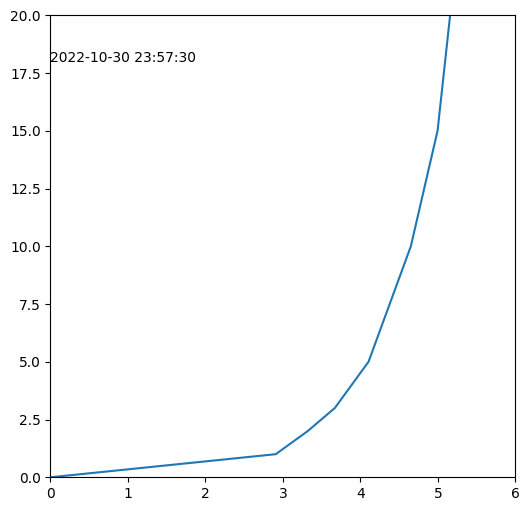

In [306]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation

fig, ax = plt.subplots(1, 1, figsize = (6, 6))

def animate(i):
    ax.cla() # clear the previous image
    chunk = dataset[ i*dataset_chunk_size : (i+1)*dataset_chunk_size]
    ax.plot(chunk['value'], chunk['height']) # plot the line
    ax.set_xlim([0, 6])
    ax.set_ylim(0, 20)
    ax.annotate(str(chunk.iloc[0].time), xy=(0, 18))


anim = animation.FuncAnimation(fig, animate, frames = range(0, int(tfinal / dt)), blit = False, interval=50)
anim.save('test.gif')

plt.show()